The goal of this notebook is to prepare reference and visum data and save them as h5ad files
Do not forget to check:
1. check presence of all necessary covariates in adata.obs
2. check number of cell per each type; cell types with less than 20 (50?) cells should be used with caution (it is better to remove them)
3. remove MT genes
4. adata.X stores raw (at least integer) read counts. Try denormalization with CalculateRaw otherwise
5. ensure that both vis and ref use same gene naming (names or ensembl ids).


In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import anndata
from collections import Counter
import glob
import math
import os
import re

In [2]:
sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.1 pandas==1.5.0 scikit-learn==1.1.2 statsmodels==0.13.2 python-igraph==0.9.11 pynndescent==0.5.7


# Reference
## load data

Set path to input reference h5ad

In [3]:
ref = sc.read_h5ad('../../../../data.nfs/from.stephane/skin/data/h5ad/fetal_skin.norm.maternal_removed.20220202.h5ad')
ref

AnnData object with n_obs × n_vars = 186533 × 28885
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'joint_annotation_20220202', 'independent_annotation_refined_20220202', 'fig1b_annotation_20220202'
    var: 'gene_ids', 'mit

In [5]:
sorted(ref.obs['joint_annotation_20220202'].unique())

['ASDC',
 'Adipocytes',
 'Arterial',
 'B cell',
 'Basal',
 'CD4 T cell',
 'CD8 T cell',
 'Capillary (venular tip)',
 'Capillary/postcapillary venule',
 'Companion layer',
 'Cuticle/cortex',
 'DC1',
 'DC2',
 'Dermal condensate',
 'Dermal papillia',
 'Early LE',
 'Early endothelial cell',
 'Early erythroid',
 'Early erythroid (embryonic)',
 'Early myocytes',
 'Eo/baso/mast cell progenitor',
 'Erythroid (embryonic)',
 'Erythroid (fetal)',
 'FRZB+ early fibroblast',
 'HOXC5+ early fibroblast',
 'HSC',
 'ILC2',
 'ILC3',
 'Immature basal',
 'Immature suprabasal',
 'Inflammatory DC',
 'Innate T type1',
 'Innate T type3',
 'Inner root sheath',
 'Iron-recycling macrophage',
 'LC',
 'LE',
 'LMCD1+ mural cell',
 'LTi',
 'LYVE1++ macrophage',
 'Lymphoid progenitor',
 'MEMP - Early erythroid',
 'MEMP - Megak',
 'MHCII+ macrophage',
 'Mast cell (earliest)',
 'Mast cell (medium)',
 'Mast cell (most mature)',
 'Matrix/placode',
 'Megakaryocyte',
 'Melanoblast',
 'Melanocyte',
 'Monocyte',
 'Monocyte (

In [7]:
pd.set_option('display.max_rows', 200)
pd.crosstab(ref.obs['joint_annotation_20220202'],ref.obs.pcw<=10)

pcw                                    False  True 
joint_annotation_20220202                          
ASDC                                      79     11
Iron-recycling macrophage                189    110
Adipocytes                              3201      2
Arterial                                 141     31
B cell                                  1953     29
Basal                                    815      0
POSTN+ basal                              46      0
CD4 T cell                              4603     72
CD8 T cell                              1506     13
Capillary (venular tip)                  414     73
Capillary/postcapillary venule           584     25
Companion layer                           27      0
Cuticle/cortex                            21      0
DC1                                      615    133
DC2                                     1870    659
Dermal condensate                       5008      5
Dermal papillia                         5637      0
Early LE                                  64      1
Early endothelial cell                     3    138
Early erythroid                          373     54
Early erythroid (embryonic)               42    378
FRZB+ early fibroblast                    53  10824
HOXC5+ early fibroblast                    4  15271
Early myocytes                           534     51
Eo/baso/mast cell progenitor             129      9
Erythroid (embryonic)                      1    681
Erythroid (fetal)                       1814    125
PEAR1+ fibroblast                       3501    286
WNT2+ fibroblast                       18064  11045
HSC                                       88     24
ILC2                                     331     74
ILC3                                     490    944
Immature basal                             2     63
Immature suprabasal                        8      7
Inflammatory DC                           62     16
Innate T type1                           637     35
Innate T type3                           211     14
Inner root sheath                         18      0
LC                                       208    171
LE                                       492     25
LTi                                      460    231
Lymphoid progenitor                       45     76
MEMP - Early erythroid                    68     21
MEMP - Megak                             187     56
MHCII+ macrophage                       1601    595
LYVE1++ macrophage                     12754   7526
Mast cell (earliest)                     141     48
Mast cell (medium)                       674     88
Mast cell (most mature)                  922     13
Matrix/placode                           254      0
Megakaryocyte                             69    104
Melanoblast                               62    128
Melanocyte                               583     21
TREM2+ macrophage                        335   1282
Monocyte                                2455    589
Monocyte (activated/differentiating)    1639    256
Monocyte precursor                      1353    381
LMCD1+ mural cell                       1068    131
PLN+ mural cell                         1799    129
Myelinating Schwann cells               1020    191
Myoblasts                               4698    477
Myocytes                                  44      7
Myofibroblasts                          2789    365
NK cell                                 5204   1618
Neuroendocrine                             0    281
Neuron progenitors                         0    649
Neutrophil1                               81      7
Neutrophil2                              109     65
Outer root sheath                         25      0
Pericytes                               5312    938
Periderm                                   2    151
Postcapillary venule                      48      0
Pre B cell                               520     21
Pre pro B cell                           122     54
Pre-dermal condensate                  13117   9

Choose between ref and ref.raw. I give priority to ref, but raw can be used if ref seems too filtered or too normlized.
Total number of genes used by 10x is above 30k, normally about 20k of them are expressed. I would consider dataset as too filtered if number of genes below 20k.

In [4]:
ref.shape

(186533, 28885)

Check raw

In [5]:
ref.raw.shape

(186533, 28885)

In [6]:
ref.X.data

array([1.8038048, 1.4774609, 1.4774609, ..., 1.6299081, 2.2199435,
       2.8572528], dtype=float32)

In [7]:
ref.raw.X.data

array([4.0688677 , 0.98987675, 2.6760242 , ..., 1.6299081 , 1.6299081 ,
       1.6299081 ], dtype=float32)

## Check genes
Check whether gene names or ensembl ids are used. If possible set to ensembl id.
This dataset has no ensembl id, so lets use gene names.

In [8]:
ref.var

gene_ids   mito   ribo     hb  n_cells     cc  \
index                                                                
RP11-34P13.3  ENSG00000243485  False  False  False        4  False   
RP11-34P13.7  ENSG00000238009  False  False  False      218  False   
RP11-34P13.8  ENSG00000239945  False  False  False        8  False   
FO538757.3    ENSG00000279928  False  False  False       97  False   
FO538757.2    ENSG00000279457  False  False  False    33427  False   
...                       ...    ...    ...    ...      ...    ...   
AC004556.1    ENSG00000276345  False  False  False     3943  False   
AC233755.2    ENSG00000277856  False  False  False       31  False   
AC233755.1    ENSG00000275063  False  False  False       41  False   
AC240274.1    ENSG00000271254  False  False  False     8958  False   
AC213203.1    ENSG00000277475  False  False  False       25  False   

                  n_counts  
index                       
RP11-34P13.3      8.317354  
RP11-34P13.7    315.864197  
RP11-34P13.8     10.248964  
FO538757.3      184.176376  
FO538757.2    62275.097656  
...                    ...  
AC004556.1     6384.311035  
AC233755.2      451.370087  
AC233755.1      540.297058  
AC240274.1    13258.359375  
AC213203.1       39.510677  

[28885 rows x 7 columns]

Check mitochondrial genes. I'll use "MT-" prefix to detect them. gene names can bo stored in various columns of var, here they are index.

In [9]:
a = [not str(gene).startswith('MT-') for gene in ref.var.index]
Counter(a)

Counter({True: 28872, False: 13})

Filter MT genes out

In [10]:
ref = ref[:,a]
ref.shape

(186533, 28872)

In [11]:
ref.var['gene_name'] = ref.var.index
ref.var.set_index('gene_ids', drop=True, inplace=True)
ref.var

/tmp/ipykernel_40919/4241633533.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ref.var['gene_name'] = ref.var.index


mito   ribo     hb  n_cells     cc      n_counts  \
gene_ids                                                             
ENSG00000243485  False  False  False        4  False      8.317354   
ENSG00000238009  False  False  False      218  False    315.864197   
ENSG00000239945  False  False  False        8  False     10.248964   
ENSG00000279928  False  False  False       97  False    184.176376   
ENSG00000279457  False  False  False    33427  False  62275.097656   
...                ...    ...    ...      ...    ...           ...   
ENSG00000276345  False  False  False     3943  False   6384.311035   
ENSG00000277856  False  False  False       31  False    451.370087   
ENSG00000275063  False  False  False       41  False    540.297058   
ENSG00000271254  False  False  False     8958  False  13258.359375   
ENSG00000277475  False  False  False       25  False     39.510677   

                    gene_name  
gene_ids                       
ENSG00000243485  RP11-34P13.3  
ENSG00000238009  RP11-34P13.7  
ENSG00000239945  RP11-34P13.8  
ENSG00000279928    FO538757.3  
ENSG00000279457    FO538757.2  
...                       ...  
ENSG00000276345    AC004556.1  
ENSG00000277856    AC233755.2  
ENSG00000275063    AC233755.1  
ENSG00000271254    AC240274.1  
ENSG00000277475    AC213203.1  

[28872 rows x 7 columns]

## Check counts
And denormalaze if necessary (using function CalculateRaw)

In [12]:
# from https://github.com/brianpenghe/python-genomics/blob/master/Scanpyplus.py
def CalculateRaw(adata,scaling_factor=10000):
    #update by Polanski in Feb 2022
    #The object must contain a log-transformed matrix
    #This function returns an integer-count object
    #The normalization constant is assumed to be 10000
    #return anndata.AnnData(X=sparse.csr_matrix(np.rint(np.array(np.expm1(adata.X).todense().transpose())*(adata.obs['n_counts'].values).transpose() / scaling_factor).transpose()),\
    #              obs=adata.obs,var=adata.var,obsm=adata.obsm,varm=adata.varm)
    X = np.expm1(adata.X)
    scaling_vector = adata.obs['n_counts'].values / scaling_factor
    #.indptr[i]:.indptr[i+1] provides the .data coordinates where the i'th row of the data resides in CSR
    #which happens to be a cell, which happens to be what we have a unique entry in scaling_vector for
    for i in np.arange(X.shape[0]):
        X.data[X.indptr[i]:X.indptr[i+1]] = X.data[X.indptr[i]:X.indptr[i+1]] * scaling_vector[i]
    return anndata.AnnData(X=np.rint(X),obs=adata.obs,var=adata.var,obsm=adata.obsm,varm=adata.varm)

Check whether numbers in X are integers

In [13]:
ref.X.data

array([1.8038048, 1.4774609, 1.4774609, ..., 2.588532 , 1.6299081,
       1.6299081], dtype=float32)

They are not, so lets try to de-normalize

In [14]:
ref = CalculateRaw(ref)
ref.X.data

array([ 3.,  2.,  2., ..., 11.,  4.,  4.], dtype=float32)

Looks interegs now, lets check totals

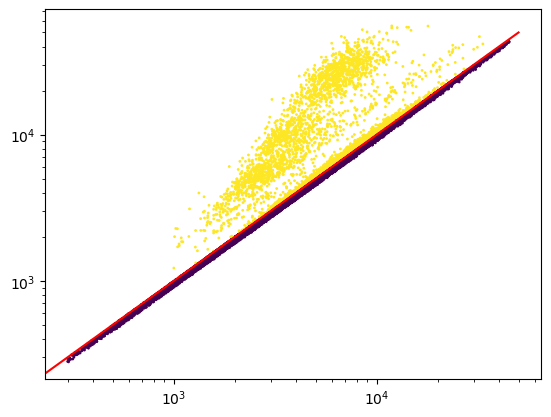

In [15]:
fig,ax=plt.subplots(1,1)
ax.scatter(ref.obs['n_counts'].values,ref.X.sum(1).tolist(),s=1,c=ref.obs.percent_hb>10)
ax.plot([0, 5e4], [0, 5e4],color='red',)
ax.set_yscale('log')
ax.set_xscale('log')
# n_counts seems to hold sums of log-normalazed data

In [16]:
z=pd.crosstab(ref.obs.joint_annotation_20220202,ref.obs.percent_hb>10)
z[z[True]>0]

percent_hb                   False  True 
joint_annotation_20220202                
Early erythroid                  0    427
Early erythroid (embryonic)      0    420
Erythroid (embryonic)            0    682
Erythroid (fetal)                0   1939

So erythroid cells cannot be denormolized (probably because hemoglobins were excluded from libarary size calculation)
I'll remove them, plus all samples with pcw > 10 and all celltypes with less than 20 cells.

In [17]:
ref = ref[(ref.obs.percent_hb<=10) & (ref.obs.pcw<=10),]
ref

View of AnnData object with n_obs × n_vars = 67509 × 28872
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_annotation_20220201', 'joint_annotation_20220202', 'independent_annotation_refined_20220202', 'fig1b_annotation_20220202'
    var: 'mito', '

Identical, so should be raw counts.

## Check obs
Check cell type annotation column ("cell type" in this case as stated  in ticket description). Check covriates (if any) and batches (10x reactions).

In [18]:
ref.obs_keys()

['sanger_id',
 'chemistry',
 'donor',
 'gender',
 'pcw',
 'sorting',
 'sample',
 'chemistry_sorting',
 'cell_caller',
 'scrublet_score',
 'cluster_scrublet_score',
 'doublet_pval',
 'bh_doublet_pval',
 'n_counts',
 'n_genes',
 'percent_mito',
 'percent_ribo',
 'percent_hb',
 'independent_annotation_refined',
 'independent_annotation_broad1',
 'independent_annotation_broad2',
 'independent_annotation_broad3',
 'independent_annotation_broad4',
 'independent_annotation_broad5',
 'joint_annotation',
 'is_maternal',
 'fig1b_annotation',
 'independent_annotation_refined_20220201a',
 'independent_annotation_refined_20220201b',
 'independent_annotation_broad1_20220201',
 'independent_annotation_broad2_20220201',
 'independent_annotation_broad3_20220201',
 'joint_annotation_20220201a',
 'joint_annotation_20220201b',
 'fig1b_annotation_20220201',
 'joint_annotation_20220202',
 'independent_annotation_refined_20220202',
 'fig1b_annotation_20220202']

In [19]:
ref.obs

sanger_id chemistry donor gender  \
index                                                                        
AAACCTGGTCAGTGGA-1-4834STDY7002879  4834STDY7002879    SC3Pv2   F16   male   
AAAGATGGTCGATTGT-1-4834STDY7002879  4834STDY7002879    SC3Pv2   F16   male   
AAAGCAAAGATGTGGC-1-4834STDY7002879  4834STDY7002879    SC3Pv2   F16   male   
AAAGTAGCAGATCGGA-1-4834STDY7002879  4834STDY7002879    SC3Pv2   F16   male   
AAAGTAGTCCGCATCT-1-4834STDY7002879  4834STDY7002879    SC3Pv2   F16   male   
...                                             ...       ...   ...    ...   
TTTGTCATCAGGCGAA-1-FCAImmP7862096    FCAImmP7862096   SC5P-R2   F61   male   
TTTGTCATCAGTTAGC-1-FCAImmP7862096    FCAImmP7862096   SC5P-R2   F61   male   
TTTGTCATCCTTCAAT-1-FCAImmP7862096    FCAImmP7862096   SC5P-R2   F61   male   
TTTGTCATCGAACGGA-1-FCAImmP7862096    FCAImmP7862096   SC5P-R2   F61   male   
TTTGTCATCGCTGATA-1-FCAImmP7862096    FCAImmP7862096   SC5P-R2   F61   male   

                                    pcw sorting           sample  \
index                                                              
AAACCTGGTCAGTGGA-1-4834STDY7002879    8   CD45P  F16_male_8+1PCW   
AAAGATGGTCGATTGT-1-4834STDY7002879    8   CD45P  F16_male_8+1PCW   
AAAGCAAAGATGTGGC-1-4834STDY7002879    8   CD45P  F16_male_8+1PCW   
AAAGTAGCAGATCGGA-1-4834STDY7002879    8   CD45P  F16_male_8+1PCW   
AAAGTAGTCCGCATCT-1-4834STDY7002879    8   CD45P  F16_male_8+1PCW   
...                                 ...     ...              ...   
TTTGTCATCAGGCGAA-1-FCAImmP7862096     7   CD45N   F61_SK_CD45N_2   
TTTGTCATCAGTTAGC-1-FCAImmP7862096     7   CD45N   F61_SK_CD45N_2   
TTTGTCATCCTTCAAT-1-FCAImmP7862096     7   CD45N   F61_SK_CD45N_2   
TTTGTCATCGAACGGA-1-FCAImmP7862096     7   CD45N   F61_SK_CD45N_2   
TTTGTCATCGCTGATA-1-FCAImmP7862096     7   CD45N   F61_SK_CD45N_2   

                                   chemistry_sorting cell_caller  \
index                                                              
AAACCTGGTCAGTGGA-1-4834STDY7002879      SC3Pv2_CD45P        Both   
AAAGATGGTCGATTGT-1-4834STDY7002879      SC3Pv2_CD45P        Both   
AAAGCAAAGATGTGGC-1-4834STDY7002879      SC3Pv2_CD45P        Both   
AAAGTAGCAGATCGGA-1-4834STDY7002879      SC3Pv2_CD45P        Both   
AAAGTAGTCCGCATCT-1-4834STDY7002879      SC3Pv2_CD45P        Both   
...                                              ...         ...   
TTTGTCATCAGGCGAA-1-FCAImmP7862096      SC5P-R2_CD45N        Both   
TTTGTCATCAGTTAGC-1-FCAImmP7862096      SC5P-R2_CD45N        Both   
TTTGTCATCCTTCAAT-1-FCAImmP7862096      SC5P-R2_CD45N        Both   
TTTGTCATCGAACGGA-1-FCAImmP7862096      SC5P-R2_CD45N        Both   
TTTGTCATCGCTGATA-1-FCAImmP7862096      SC5P-R2_CD45N        Both   

                                    scrublet_score  ...  \
index                                               ...   
AAACCTGGTCAGTGGA-1-4834STDY7002879        0.225806  ...   
AAAGATGGTCGATTGT-1-4834STDY7002879        0.149606  ...   
AAAGCAAAGATGTGGC-1-4834STDY7002879        0.201970  ...   
AAAGTAGCAGATCGGA-1-4834STDY7002879        0.164557  ...   
AAAGTAGTCCGCATCT-1-4834STDY7002879        0.181818  ...   
...                                            ...  ...   
TTTGTCATCAGGCGAA-1-FCAImmP7862096         0.138298  ...   
TTTGTCATCAGTTAGC-1-FCAImmP7862096         0.333333  ...   
TTTGTCATCCTTCAAT-1-FCAImmP7862096         0.394495  ...   
TTTGTCATCGAACGGA-1-FCAImmP7862096         0.351801  ...   
TTTGTCATCGCTGATA-1-FCAImmP7862096         0.188648  ...   

                                    independent_annotation_refined_20220201b  \
index                                                                          
AAACCTGGTCAGTGGA-1-4834STDY7002879                                Macrophage   
AAAGATGGTCGATTGT-1-4834STDY7002879      Monocyte (activated/differentiating)   
AAAGCAAAGATGTGGC-1-4834STDY7002879                                Macrophage   
AAAGTAGCAGATCGGA-1-4834STDY7002879              Eo/baso/mast cell progenitor   
AAAGTAGTC

Seems that batch information is given in "batch" column. It might be "id" or any other column. It could  absent as well.

In [20]:
ref.obs['sanger_id'].value_counts()

FCAImmP7316897     7028
FCAImmP7862096     6653
FCAImmP7862095     6318
FCAImmP7316888     5843
FCAImmP7352190     5202
FCAImmP7352191     5100
FCAImmP7241241     4939
FCAImmP7462241     4536
FCAImmP7316886     3876
FCAImmP7316887     3511
FCAImmP7462240     3387
FCAImmP7862094     2790
FCAImmP7316896     2716
FCAImmP7352189     2502
4834STDY7002883    1070
4834STDY7038753     773
4834STDY7002879     530
4834STDY7002880     288
FCAImmP7241240      267
4834STDY7038752     180
Name: sanger_id, dtype: int64

In [21]:
ref.obs['donor'].value_counts()

F61    15761
F33    13230
F34    12804
F32     9744
F35     7923
F19     5206
F17     2023
F16      818
Name: donor, dtype: int64

In [22]:
ref.obs['chemistry'].value_counts()

SC3Pv2     51748
SC5P-R2    15761
Name: chemistry, dtype: int64

In [23]:
# rename celltypes
cellRenamer = {'Postcapillary venule':'Venules',
               'Capillary/postcapillary venule':'Postcapillary venules',
               'Capillary (venular tip)':'Capillaries',
               'Tip cell (arterial)':'Capillary arterioles',
               'Arterial':'Arterioles',
               'Early endothelial cell':'Early endothelial cells'}

In [24]:
set(cellRenamer.keys()).difference(ref.obs.joint_annotation_20220202)

{'Postcapillary venule'}

In [25]:
sorted(ref.obs['joint_annotation_20220202'].unique())

['ASDC',
 'Adipocytes',
 'Arterial',
 'B cell',
 'CD4 T cell',
 'CD8 T cell',
 'Capillary (venular tip)',
 'Capillary/postcapillary venule',
 'DC1',
 'DC2',
 'Dermal condensate',
 'Early LE',
 'Early endothelial cell',
 'Early myocytes',
 'Eo/baso/mast cell progenitor',
 'FRZB+ early fibroblast',
 'HOXC5+ early fibroblast',
 'HSC',
 'ILC2',
 'ILC3',
 'Immature basal',
 'Immature suprabasal',
 'Inflammatory DC',
 'Innate T type1',
 'Innate T type3',
 'Iron-recycling macrophage',
 'LC',
 'LE',
 'LMCD1+ mural cell',
 'LTi',
 'LYVE1++ macrophage',
 'Lymphoid progenitor',
 'MEMP - Early erythroid',
 'MEMP - Megak',
 'MHCII+ macrophage',
 'Mast cell (earliest)',
 'Mast cell (medium)',
 'Mast cell (most mature)',
 'Megakaryocyte',
 'Melanoblast',
 'Melanocyte',
 'Monocyte',
 'Monocyte (activated/differentiating)',
 'Monocyte precursor',
 'Myelinating Schwann cells',
 'Myoblasts',
 'Myocytes',
 'Myofibroblasts',
 'NK cell',
 'Neuroendocrine',
 'Neuron progenitors',
 'Neutrophil1',
 'Neutrophil

In [26]:
ref.obs['joint_annotation_20220202'] = ref.obs.joint_annotation_20220202.replace(cellRenamer)

/tmp/ipykernel_40919/764138428.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ref.obs['joint_annotation_20220202'] = ref.obs.joint_annotation_20220202.replace(cellRenamer)


In [27]:
set(cellRenamer.keys()).difference(ref.obs.joint_annotation_20220202)

{'Arterial',
 'Capillary (venular tip)',
 'Capillary/postcapillary venule',
 'Early endothelial cell',
 'Postcapillary venule',
 'Tip cell (arterial)'}

In [29]:
cc = ref.obs.joint_annotation_20220202.value_counts()
cc[cc<10]

Eo/baso/mast cell progenitor    9
Treg                            9
Immature suprabasal             7
Myocytes                        7
Neutrophil1                     7
Dermal condensate               5
Adipocytes                      2
Early LE                        1
Name: joint_annotation_20220202, dtype: int64

In [31]:
ctf = ref.obs['joint_annotation_20220202'].isin(cc.index[cc>=10].tolist())
Counter(ctf)

Counter({True: 67462, False: 47})

Remove rare cell types if necessary and save filtered dataset.

In [32]:
reff = ref[ctf,:]
reff.shape

(67462, 28872)

In [33]:
sc.write(adata=reff,filename="../../../../data.nfs/my/visium/skin.c2l/fetal_skin.norm.maternal_removed.20220202.filtered10.denorm.h5ad")

Only considering the two last: ['.denorm', '.h5ad'].
Only considering the two last: ['.denorm', '.h5ad'].


Check rare cell types (there are no of them in this dataset)

In [34]:
cc = ref.obs.joint_annotation_20220202.value_counts()
cc[cc<20]

Inflammatory DC                 16
Innate T type3                  14
CD8 T cell                      13
Mast cell (most mature)         13
ASDC                            11
Eo/baso/mast cell progenitor     9
Treg                             9
Immature suprabasal              7
Myocytes                         7
Neutrophil1                      7
Dermal condensate                5
Adipocytes                       2
Early LE                         1
Name: joint_annotation_20220202, dtype: int64

In [35]:
ctf = ref.obs['joint_annotation_20220202'].isin(cc.index[cc>=20].tolist())
Counter(ctf)

Counter({True: 67395, False: 114})

Remove rare cell types if necessary and save filtered dataset.

In [30]:
reff = ref[ctf,:]
reff.shape

(67395, 28872)

In [31]:
sc.write(adata=reff,filename="../../../../data.nfs/my/visium/skin.c2l/fetal_skin.norm.maternal_removed.20220202.filtered.denorm.h5ad")

Only considering the two last: ['.denorm', '.h5ad'].
Only considering the two last: ['.denorm', '.h5ad'].


# Make pseudobulk (optional, can be used to check signatures)

In [36]:
a=[reff.X[reff.obs.joint_annotation_20220202==ct,].sum(0)[0] for ct in reff.obs.joint_annotation_20220202.cat.categories]
b = np.asarray(a, dtype=float)
b=b[:,0,:].transpose()

In [38]:
b = pd.DataFrame(b) 
b.index = reff.var.index
b.columns = reff.obs.joint_annotation_20220202.cat.categories.astype('str')
b

Iron-recycling macrophage  Arterioles  B cell  CD4 T cell  \
gene_ids                                                                     
ENSG00000243485                        0.0         0.0     0.0         0.0   
ENSG00000238009                        0.0         0.0     0.0         0.0   
ENSG00000239945                        0.0         0.0     0.0         0.0   
ENSG00000279928                        0.0         0.0     0.0         0.0   
ENSG00000279457                       46.0         3.0     2.0         7.0   
...                                    ...         ...     ...         ...   
ENSG00000276345                       16.0         0.0     0.0         3.0   
ENSG00000277856                        0.0         0.0     0.0         0.0   
ENSG00000275063                        0.0         0.0     0.0         0.0   
ENSG00000271254                        8.0         0.0     0.0         0.0   
ENSG00000277475                        0.0         0.0     0.0         0.0   

                 Capillaries  Postcapillary venules   DC1    DC2  \
gene_ids                                                           
ENSG00000243485          0.0                    0.0   0.0    0.0   
ENSG00000238009          0.0                    0.0   2.0    0.0   
ENSG00000239945          0.0                    0.0   0.0    0.0   
ENSG00000279928          0.0                    0.0   0.0    0.0   
ENSG00000279457         21.0                    8.0  37.0  206.0   
...                      ...                    ...   ...    ...   
ENSG00000276345          0.0                    0.0  22.0  130.0   
ENSG00000277856          0.0                    0.0   0.0    0.0   
ENSG00000275063          0.0                    0.0   0.0    0.0   
ENSG00000271254          4.0                    0.0   9.0   25.0   
ENSG00000277475          0.0                    0.0   0.0    0.0   

                 Early endothelial cells  FRZB+ early fibroblast  ...  \
gene_ids                                                          ...   
ENSG00000243485                      0.0                     0.0  ...   
ENSG00000238009                      0.0                     7.0  ...   
ENSG00000239945                      0.0                     0.0  ...   
ENSG00000279928                      0.0                     2.0  ...   
ENSG00000279457                     36.0                  1591.0  ...   
...                                  ...                     ...  ...   
ENSG00000276345                      0.0                     6.0  ...   
ENSG00000277856                      0.0                     0.0  ...   
ENSG00000275063                      0.0                     0.0  ...   
ENSG00000271254                      1.0                   404.0  ...   
ENSG00000277475                      0.0                     0.0  ...   

                 Periderm  Pre B cell  Pre pro B cell  Pre-dermal condensate  \
gene_ids                                                                       
ENSG00000243485       0.0         0.0             0.0                    0.0   
ENSG00000238009       0.0         0.0             0.0                   22.0   
ENSG00000239945       0.0         0.0             0.0                    0.0   
ENSG00000279928       0.0         0.0             0.0                    0.0   
ENSG00000279457      45.0         6.0            20.0                 2488.0   
...                   ...         ...             ...                    ...   
ENSG00000276345       0.0         0.0            20.0                  181.0   
ENSG00000277856       0.0         0.0             1.0                    0.0   
ENSG00000275063       0.0         0.0             0.0                    0.0   
ENSG00000271254       4.0         0.0             1.0                 1163.0   
ENSG00000277475       0.0         0.0             0.0                    0.0   

                 Pro B cell  SPP1+ proliferating neuron proneitors  \
gene_ids                                                

In [39]:
b.to_csv("../../../../data.nfs/my/visium/skin.c2l/fetal_skin.norm.maternal_removed.20220202.filtered.denorm.pseudobulk.csv")

In [40]:
ref.obs.joint_annotation_20220202.value_counts().to_csv("../../../../data.nfs/my/visium/skin.c2l/fetal_skin.norm.maternal_removed.20220202.filtered.denorm.cellcounts.csv")

# Visium

In [2]:
path2spacerangers = '../../../../data.lustre/visium/spaceranger/'
sids = pd.read_csv('../samples.csv')
sids
#sids = sids[sids.sid!='WSSS_THYst9383360'].reset_index() # no skin here
#sids

Sanger_id     GA     PCW       site  PCD
0   WSSS_THYst9383359   10w1     NaN       limb   57
1   WSSS_THYst9383361   10w1     NaN       limb   57
2   WSSS_THYst9383362   10w1     NaN       limb   57
3   WSSS_THYst9699523    8w4  6.1pcw       limb   43
4   WSSS_THYst9699524    8w4  6.1pcw       limb   43
5   WSSS_THYst9699525   7w4d  6.2pcw       limb   43
6   WSSS_THYst9699526   7w4d  6.2pcw       limb   43
7   HCA_rFSKI13460601  12w5d   10pcw     facial   70
8   HCA_rFSKI13460602  12w5d   10pcw     facial   70
9   HCA_rFSKI13460603  12w5d   10pcw  abdominal   70
10  HCA_rFSKI13460604  12w5d   10pcw  abdominal   70

Load visium. I'll load all spots including empty ones for later use in QC.

In [3]:
# you may need to run it due to incompatibility of scanpy with new spaceranger
# for i in `ls -1 */outs/spatial/tissue_positions.csv | sed s/.csv//`; do echo $i;tail -n +2 $i.csv > ${i}_list.csv; done
vs = {f:sc.read_visium(path2spacerangers+'/'+f+"/outs/",count_file='raw_feature_bc_matrix.h5',library_id=f) for f in sids.Sanger_id} # to load from unmodified soaceranger output (with outs folder)

/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py

In [4]:
vs[sids.Sanger_id[0]].obs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4992 entries, AAACAACGAATAGTTC-1 to TTGTTTGTGTAAATTC-1
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   in_tissue  4992 non-null   int64
 1   array_row  4992 non-null   int64
 2   array_col  4992 non-null   int64
dtypes: int64(3)
memory usage: 156.0+ KB


Prepare visiums

In [5]:
for i in sids.Sanger_id:
    vs[i].obs['barcode'] = vs[i].obs_names
    vs[i].obs_names = i + '_'+ vs[i].obs_names
    vs[i].obs['library_id']=i
    vs[i].var_names_make_unique()    
    vs[i].obs['n_counts'] = vs[i].X.sum(1)
    vs[i].obs['ln_counts'] = np.log10(vs[i].obs['n_counts']+1)
    vs[i].obsm['spatial'] = vs[i].obsm['spatial'].astype(int)

{k:x.shape[0] for (k,x) in vs.items()}

{'WSSS_THYst9383359': 4992,
 'WSSS_THYst9383361': 4992,
 'WSSS_THYst9383362': 4992,
 'WSSS_THYst9699523': 4991,
 'WSSS_THYst9699524': 4990,
 'WSSS_THYst9699525': 4988,
 'WSSS_THYst9699526': 4991,
 'HCA_rFSKI13460601': 4988,
 'HCA_rFSKI13460602': 4992,
 'HCA_rFSKI13460603': 4992,
 'HCA_rFSKI13460604': 4986}

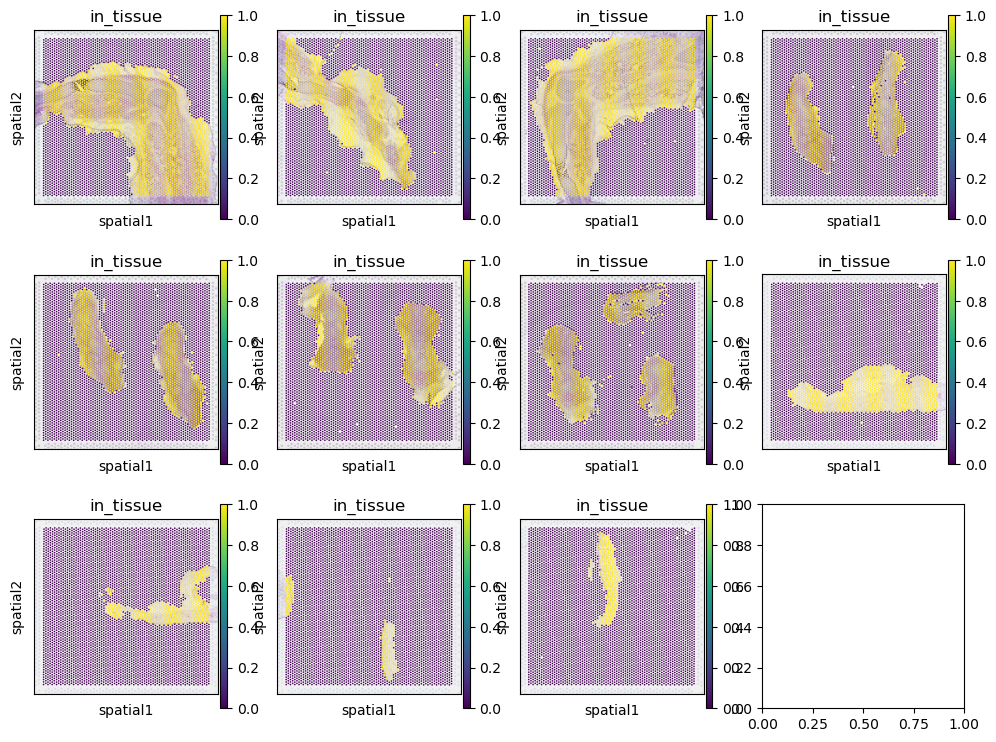

In [6]:
fig,ax = plt.subplots(3,4,figsize=(12,9))
ax = ax.flatten()
for i in range(0,sids.shape[0]):
    sc.pl.spatial(vs[sids.Sanger_id[i]],color='in_tissue',ax=ax[i],show=False)

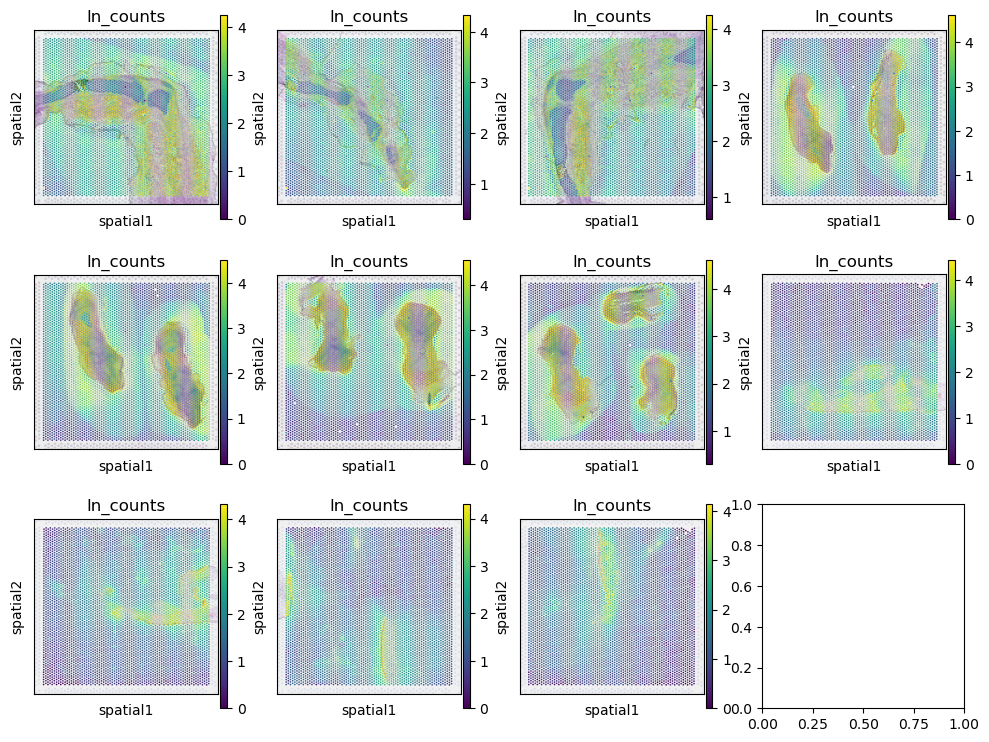

In [7]:
fig,ax = plt.subplots(3,4,figsize=(12,9))
ax = ax.flatten()
for i in range(0,sids.shape[0]):
    sc.pl.spatial(vs[sids.Sanger_id[i]],color='ln_counts',ax=ax[i],show=False)

## Mark skin on limb
using manuall annotation bade in loupe browser

In [10]:
for s in sids.Sanger_id[sids.site=='limb']:
    print(s)
    a = pd.read_csv('../../../../data.nfs/my/visium/man.ann/'+s+'.csv')
    vs[s].obs.in_tissue = 0
    vs[s].obs.loc[vs[s].obs.barcode.isin(a.Barcode[a.annot=='skin']),'in_tissue'] = 1


WSSS_THYst9383359
WSSS_THYst9383361
WSSS_THYst9383362
WSSS_THYst9699523
WSSS_THYst9699524
WSSS_THYst9699525
WSSS_THYst9699526


## Remove non skin from face/body

In [11]:
for s in sids.Sanger_id[sids.site!='limb']:
    print(s)
    a = pd.read_csv('../../../../data.nfs/my/visium/man.ann/'+s+'.csv')
    vs[s].obs.loc[vs[s].obs.barcode.isin(a.Barcode[a.ann=='not_tissue']),'in_tissue'] = 0


HCA_rFSKI13460601
HCA_rFSKI13460602
HCA_rFSKI13460603
HCA_rFSKI13460604


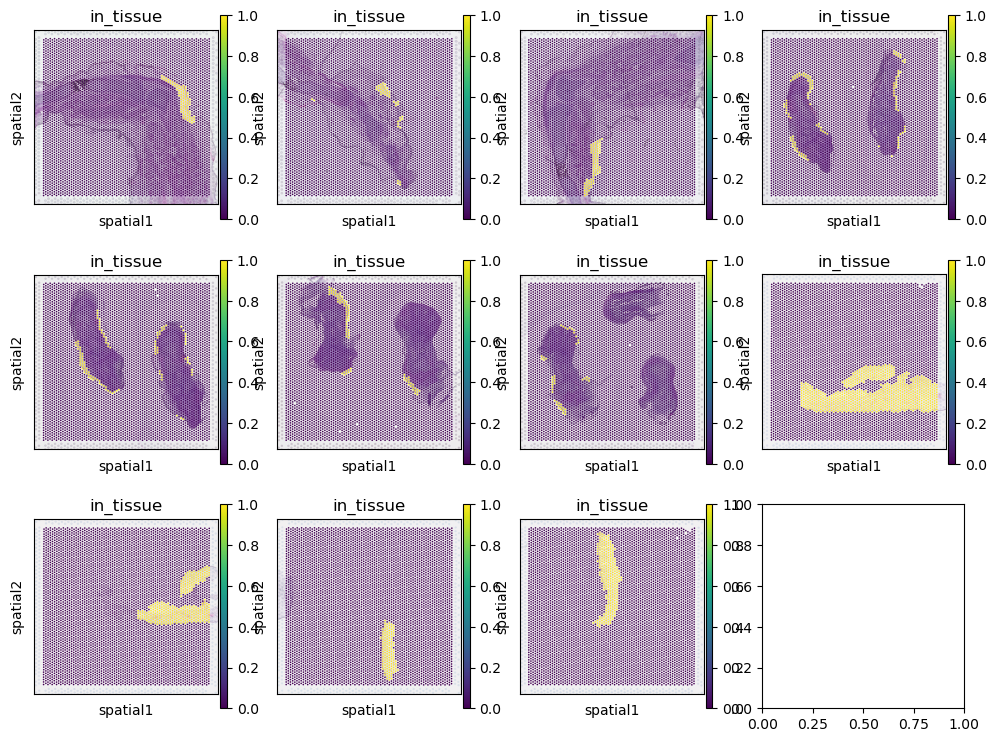

In [12]:
fig,ax = plt.subplots(3,4,figsize=(12,9))
ax = ax.flatten()
for i in range(0,sids.shape[0]):
    sc.pl.spatial(vs[sids.Sanger_id[i]],color='in_tissue',ax=ax[i],show=False)

In [13]:
vsl = list(vs.values())
vis = vsl[0].concatenate(vsl[1:],uns_merge='unique')
vis

/home/jovyan/my-conda-envs/scvi-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 54894 × 33694
    obs: 'in_tissue', 'array_row', 'array_col', 'barcode', 'library_id', 'n_counts', 'ln_counts', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [14]:
vis.obs

in_tissue  array_row  array_col  \
WSSS_THYst9383359_AAACAACGAATAGTTC-1-0           0          0         16   
WSSS_THYst9383359_AAACAAGTATCTCCCA-1-0           0         50        102   
WSSS_THYst9383359_AAACAATCTACTAGCA-1-0           0          3         43   
WSSS_THYst9383359_AAACACCAATAACTGC-1-0           0         59         19   
WSSS_THYst9383359_AAACAGAGCGACTCCT-1-0           0         14         94   
...                                            ...        ...        ...   
HCA_rFSKI13460604_TTGTTTCACATCCAGG-1-10          0         58         42   
HCA_rFSKI13460604_TTGTTTCATTAGTCTA-1-10          0         60         30   
HCA_rFSKI13460604_TTGTTTCCATACAACT-1-10          0         45         27   
HCA_rFSKI13460604_TTGTTTGTATTACACG-1-10          0         73         41   
HCA_rFSKI13460604_TTGTTTGTGTAAATTC-1-10          0          7         51   

                                                    barcode  \
WSSS_THYst9383359_AAACAACGAATAGTTC-1-0   AAACAACGAATAGTTC-1   
WSSS_THYst9383359_AAACAAGTATCTCCCA-1-0   AAACAAGTATCTCCCA-1   
WSSS_THYst9383359_AAACAATCTACTAGCA-1-0   AAACAATCTACTAGCA-1   
WSSS_THYst9383359_AAACACCAATAACTGC-1-0   AAACACCAATAACTGC-1   
WSSS_THYst9383359_AAACAGAGCGACTCCT-1-0   AAACAGAGCGACTCCT-1   
...                                                     ...   
HCA_rFSKI13460604_TTGTTTCACATCCAGG-1-10  TTGTTTCACATCCAGG-1   
HCA_rFSKI13460604_TTGTTTCATTAGTCTA-1-10  TTGTTTCATTAGTCTA-1   
HCA_rFSKI13460604_TTGTTTCCATACAACT-1-10  TTGTTTCCATACAACT-1   
HCA_rFSKI13460604_TTGTTTGTATTACACG-1-10  TTGTTTGTATTACACG-1   
HCA_rFSKI13460604_TTGTTTGTGTAAATTC-1-10  TTGTTTGTGTAAATTC-1   

                                                library_id  n_counts  \
WSSS_THYst9383359_AAACAACGAATAGTTC-1-0   WSSS_THYst9383359      43.0   
WSSS_THYst9383359_AAACAAGTATCTCCCA-1-0   WSSS_THYst9383359    2065.0   
WSSS_THYst9383359_AAACAATCTACTAGCA-1-0   WSSS_THYst9383359     473.0   
WSSS_THYst9383359_AAACACCAATAACTGC-1-0   WSSS_THYst9383359    8684.0   
WSSS_THYst9383359_AAACAGAGCGACTCCT-1-0   WSSS_THYst9383359    2453.0   
...                                                    ...       ...   
HCA_rFSKI13460604_TTGTTTCACATCCAGG-1-10  HCA_rFSKI13460604       5.0   
HCA_rFSKI13460604_TTGTTTCATTAGTCTA-1-10  HCA_rFSKI13460604       7.0   
HCA_rFSKI13460604_TTGTTTCCATACAACT-1-10  HCA_rFSKI13460604      11.0   
HCA_rFSKI13460604_TTGTTTGTATTACACG-1-10  HCA_rFSKI13460604       2.0   
HCA_rFSKI13460604_TTGTTTGTGTAAATTC-1-10  HCA_rFSKI13460604      26.0   

                                         ln_counts batch  
WSSS_THYst9383359_AAACAACGAATAGTTC-1-0    1.643453     0  
WSSS_THYst9383359_AAACAAGTATCTCCCA-1-0    3.315130     0  
WSSS_THYst9383359_AAACAATCTACTAGCA-1-0    2.675778     0  
WSSS_THYst9383359_AAACACCAATAACTGC-1-0    3.938770     0  
WSSS_THYst9383359_AAACAGAGCGACTCCT-1-0    3.389875     0  
...                                            ...   ...  
HCA_rFSKI13460604_TTGTTTCACATCCAGG-1-10   0.778151    10  
HCA_rFSKI13460604_TTGTTTCATTAGTCTA-1-10   0.903090    10  
HCA_rFSKI13460604_TTGTTTCCATACAACT-1-10   1.079181    10  
HCA_rFSKI13460604_TTGTTTGTATTACACG-1-10   0.477121    10  
HCA_rFSKI13460604_TTGTTTGTGTAAATTC-1-10   1.431364    10  

[54894 rows x 8 columns]

Ltes make spot names more meaningfull

In [15]:
# hope "|" is allowed in index
vis.obs_names = vis.obs['library_id'] + "|" + vis.obs['barcode']
vis.obs = vis.obs.drop(columns='batch',errors='ignore')
vis.obs

in_tissue  array_row  array_col  \
WSSS_THYst9383359|AAACAACGAATAGTTC-1          0          0         16   
WSSS_THYst9383359|AAACAAGTATCTCCCA-1          0         50        102   
WSSS_THYst9383359|AAACAATCTACTAGCA-1          0          3         43   
WSSS_THYst9383359|AAACACCAATAACTGC-1          0         59         19   
WSSS_THYst9383359|AAACAGAGCGACTCCT-1          0         14         94   
...                                         ...        ...        ...   
HCA_rFSKI13460604|TTGTTTCACATCCAGG-1          0         58         42   
HCA_rFSKI13460604|TTGTTTCATTAGTCTA-1          0         60         30   
HCA_rFSKI13460604|TTGTTTCCATACAACT-1          0         45         27   
HCA_rFSKI13460604|TTGTTTGTATTACACG-1          0         73         41   
HCA_rFSKI13460604|TTGTTTGTGTAAATTC-1          0          7         51   

                                                 barcode         library_id  \
WSSS_THYst9383359|AAACAACGAATAGTTC-1  AAACAACGAATAGTTC-1  WSSS_THYst9383359   
WSSS_THYst9383359|AAACAAGTATCTCCCA-1  AAACAAGTATCTCCCA-1  WSSS_THYst9383359   
WSSS_THYst9383359|AAACAATCTACTAGCA-1  AAACAATCTACTAGCA-1  WSSS_THYst9383359   
WSSS_THYst9383359|AAACACCAATAACTGC-1  AAACACCAATAACTGC-1  WSSS_THYst9383359   
WSSS_THYst9383359|AAACAGAGCGACTCCT-1  AAACAGAGCGACTCCT-1  WSSS_THYst9383359   
...                                                  ...                ...   
HCA_rFSKI13460604|TTGTTTCACATCCAGG-1  TTGTTTCACATCCAGG-1  HCA_rFSKI13460604   
HCA_rFSKI13460604|TTGTTTCATTAGTCTA-1  TTGTTTCATTAGTCTA-1  HCA_rFSKI13460604   
HCA_rFSKI13460604|TTGTTTCCATACAACT-1  TTGTTTCCATACAACT-1  HCA_rFSKI13460604   
HCA_rFSKI13460604|TTGTTTGTATTACACG-1  TTGTTTGTATTACACG-1  HCA_rFSKI13460604   
HCA_rFSKI13460604|TTGTTTGTGTAAATTC-1  TTGTTTGTGTAAATTC-1  HCA_rFSKI13460604   

                                      n_counts  ln_counts  
WSSS_THYst9383359|AAACAACGAATAGTTC-1      43.0   1.643453  
WSSS_THYst9383359|AAACAAGTATCTCCCA-1    2065.0   3.315130  
WSSS_THYst9383359|AAACAATCTACTAGCA-1     473.0   2.675778  
WSSS_THYst9383359|AAACACCAATAACTGC-1    8684.0   3.938770  
WSSS_THYst9383359|AAACAGAGCGACTCCT-1    2453.0   3.389875  
...                                        ...        ...  
HCA_rFSKI13460604|TTGTTTCACATCCAGG-1       5.0   0.778151  
HCA_rFSKI13460604|TTGTTTCATTAGTCTA-1       7.0   0.903090  
HCA_rFSKI13460604|TTGTTTCCATACAACT-1      11.0   1.079181  
HCA_rFSKI13460604|TTGTTTGTATTACACG-1       2.0   0.477121  
HCA_rFSKI13460604|TTGTTTGTGTAAATTC-1      26.0   1.431364  

[54894 rows x 7 columns]

In [16]:
vis.var['gene_name'] = vis.var.index
vis.var = vis.var.set_index('gene_ids')
vis.var

feature_types  genome     gene_name
gene_ids                                              
ENSG00000243485  Gene Expression  GRCh38  RP11-34P13.3
ENSG00000237613  Gene Expression  GRCh38       FAM138A
ENSG00000186092  Gene Expression  GRCh38         OR4F5
ENSG00000238009  Gene Expression  GRCh38  RP11-34P13.7
ENSG00000239945  Gene Expression  GRCh38  RP11-34P13.8
...                          ...     ...           ...
ENSG00000277856  Gene Expression  GRCh38    AC233755.2
ENSG00000275063  Gene Expression  GRCh38    AC233755.1
ENSG00000271254  Gene Expression  GRCh38    AC240274.1
ENSG00000277475  Gene Expression  GRCh38    AC213203.1
ENSG00000268674  Gene Expression  GRCh38       FAM231B

[33694 rows x 3 columns]

In [16]:
vis.write("../../../../data.nfs/my/visium/skin.c2l/viss.h5ad")